# Model Training

In [180]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import datetime
from numpy import inf
from scipy.stats import randint as sp_randint
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import model_selection
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost

In [181]:
training_dataset = pd.read_csv('../2_database/data_processing/02_03_training_dataset.csv',
                               sep=';')

validation_dataset = pd.read_csv('../2_database/data_processing/02_03_validation_dataset.csv',
                                 sep=';')

In [182]:
print("Training and Validation size: " + str(training_dataset.shape) + " / " + str(validation_dataset.shape))

Training and Validation size: (420, 53) / (140, 53)


In [183]:
training_dataset.head()

,pct_pol_neg_rel,education_var_01_quantity_pct,family_var_01_suitable_pct,family_var_01_semi_suitable_pct,family_var_01_inappropriate_pct,fertility_var_01_has_children_pct,fertility_var_01_children_born_pct,fertility_var_01_children_borned_live_pct,fertility_var_01_children_borned_dead_pct,fertility_var_02_married_pct,...,state_pr,state_rj,state_rn,state_ro,state_rr,state_rs,state_sc,state_se,state_sp,state_to
0,0.350775,1.117053,0.000000,0.993414,1.667300,0.946110,1.059396,1.034859,1.747131,1.032382,...,0,0,0,0,0,0,1,0,0,0
1,0.267845,1.114802,0.952957,1.169540,47.418210,1.001920,1.150179,1.138941,1.531662,1.138413,...,0,0,0,0,0,0,1,0,0,0
2,0.408816,1.035698,0.616752,1.170773,2.452725,0.969964,1.330319,1.317376,1.571041,1.042142,...,0,0,0,0,0,0,0,0,0,0
3,0.414336,0.970031,0.876919,1.228749,2.848914,0.962917,1.129891,1.123553,1.258481,1.075063,...,0,0,0,0,0,0,0,0,0,0
4,0.359050,1.009907,0.734807,1.617280,9.239346,0.955090,1.159441,1.180107,0.803960,1.046754,...,0,0,0,0,0,0,0,0,1,0


In [184]:
for col in training_dataset.columns:
    print(col)

pct_pol_neg_rel
education_var_01_quantity_pct
family_var_01_suitable_pct
family_var_01_semi_suitable_pct
family_var_01_inappropriate_pct
fertility_var_01_has_children_pct
fertility_var_01_children_born_pct
fertility_var_01_children_borned_live_pct
fertility_var_01_children_borned_dead_pct
fertility_var_02_married_pct
fertility_var_02_separated_pct
fertility_var_02_divorced_pct
fertility_var_02_widow_pct
fertility_var_02_single_pct
fertility_var_03_total_pct
work_var_01_regular_pct
work_var_01_irregular_pct
social_indicator_var_01_15_to_24_years_pct
social_indicator_var_01_25_to_59_years_pct
social_indicator_var_01_60_to_more_years_pct
social_indicator_var_02_suitable_pct
social_indicator_var_02_semi_suitable_pct
social_indicator_var_02_inappropriate_pct
social_indicator_var_03_responsable_illiterate_pct
social_indicator_var_03_inappropriate_residence_pct
social_indicator_var_03_responsable_illiterate_and_inappropriate_residence_pct
enem_var_01_enem_score_mean_pct
enem_var_01_enem_score

In [185]:
array = training_dataset.values

X_training = array[:, 1:]
Y_training = array[:, 0]

In [186]:
array = validation_dataset.values

X_validation = array[:, 1:]
Y_validation = array[:, 0]

### Function for regression evaluation

In [187]:
def regression_evaluation(Y_training, y_training_pred, Y_validation, y_validation_pred):
    random_simulation = np.random.randint(int(np.quantile(Y_training, 0)*10), int(np.quantile(Y_training, 1)*10), size=len(Y_validation)) * 0.1

    print("RMSE training: " + str(np.round(np.sqrt(mean_squared_error(Y_training, y_training_pred)), 4)) + "\n" +
          "RMSE validation: " + str(np.round(np.sqrt(mean_squared_error(Y_validation, y_validation_pred)), 4)) + "\n" + 
          "RMSE validation random model: " + str(np.round(np.sqrt(mean_squared_error(Y_validation, random_simulation)), 4)))

    print("\n")
    
    delta = 0.15
    
    overestimate_training_rate = np.round(sum((y_training_pred > Y_training * (1 + delta)) == True)/len(Y_training), 4)
    underestimate_training_rate = np.round(sum((y_training_pred < Y_training * (1 - delta)) == True)/len(Y_training), 4)
    wellestimate_training_rate = np.round(1-(overestimate_training_rate + underestimate_training_rate), 4)
    
    overestimate_validation_rate = np.round(sum((y_validation_pred > Y_validation * (1 + delta)) == True)/len(Y_validation), 4)
    underestimate_validation_rate = np.round(sum((y_validation_pred < Y_validation * (1 - delta)) == True)/len(Y_validation), 4)
    wellestimate_validation_rate = np.round(1-(overestimate_validation_rate + underestimate_validation_rate), 4)
    
    overestimate_random_rate = np.round(sum((random_simulation > Y_validation * (1 + delta)) == True)/len(Y_validation), 4)
    underestimate_random_rate = np.round(sum((random_simulation < Y_validation * (1 - delta)) == True)/len(Y_validation), 4)
    wellestimate_random_rate = np.round(1-(overestimate_random_rate + underestimate_random_rate), 4)
    
    print("BANDS training (underestimate | well | overestimate): " + str(underestimate_training_rate) + " | " + str(wellestimate_training_rate) + " | " + str(overestimate_training_rate) + "\n" + 
          "BANDS validation (underestimate | well | overestimate): " + str(underestimate_validation_rate) + " | " + str(wellestimate_validation_rate) + " | " + str(overestimate_validation_rate) + "\n" + 
          "BANDS validation random model (underestimate | well | overestimate): " + str(underestimate_random_rate) + " | " + str(wellestimate_random_rate) + " | " + str(overestimate_random_rate))
    
    plt.ylabel("predicted")
    plt.xlabel("observed")
    plt.scatter(Y_training, y_training_pred, label='training')
    plt.scatter(Y_validation, y_validation_pred, label='validation')
    plt.legend()

### 1 - Linear Regression

In [188]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_training, Y_training)

y_training_pred = linear_regression_model.predict(X_training)
y_validation_pred = linear_regression_model.predict(X_validation)

RMSE training: 0.0484
RMSE validation: 0.0628
RMSE validation random model: 0.1962


BANDS training (underestimate | well | overestimate): 0.0643 | 0.8095 | 0.1262
BANDS validation (underestimate | well | overestimate): 0.1286 | 0.6928 | 0.1786
BANDS validation random model (underestimate | well | overestimate): 0.5071 | 0.1286 | 0.3643


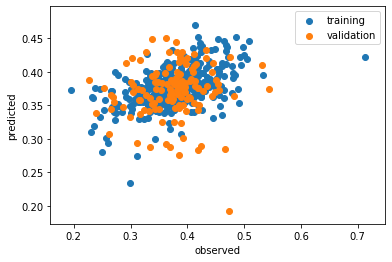

In [189]:
regression_evaluation(Y_training,
                      y_training_pred,
                      Y_validation,
                      y_validation_pred)

### 2 - Random Forest

In [190]:
random_forest_model = RandomForestRegressor()

params = {"max_depth": sp_randint(2, 10),
              "max_features": sp_randint(5, len(training_dataset.columns)-1),
              "n_estimators": [10, 25, 50, 75],
              "bootstrap": [True, False],
              "criterion": ["mse"]}

rs_random_forest_model = RandomizedSearchCV(random_forest_model,
                                            param_distributions=params,
                                            n_iter=50,
                                            cv=5,
                                            iid=False)

rs_random_forest_model.fit(X_training, Y_training)

y_training_pred = rs_random_forest_model.predict(X_training)
y_validation_pred = rs_random_forest_model.predict(X_validation)

RMSE training: 0.0478
RMSE validation: 0.0521
RMSE validation random model: 0.185


BANDS training (underestimate | well | overestimate): 0.0833 | 0.781 | 0.1357
BANDS validation (underestimate | well | overestimate): 0.0786 | 0.7571 | 0.1643
BANDS validation random model (underestimate | well | overestimate): 0.4571 | 0.2 | 0.3429


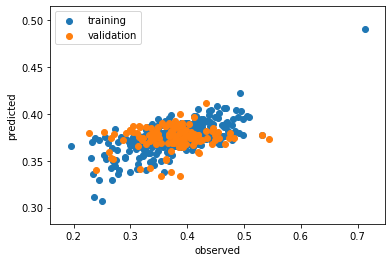

In [191]:
regression_evaluation(Y_training,
                      y_training_pred,
                      Y_validation,
                      y_validation_pred)

In [192]:
rs_random_forest_model.best_params_

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 3,
 'max_features': 19,
 'n_estimators': 50}

### 3 - XGBoost

In [193]:
xgboost_model = xgboost.XGBRegressor()

param_grid = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        #'gamma': [0, 0.25, 0.5, 1.0],
        #'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100]}

#fit_params = {'eval_metric': 'mlogloss',
#              'early_stopping_rounds': 10,
#              'eval_set': [(X_validation, Y_validation)]}

rs_xgboost_model = RandomizedSearchCV(xgboost_model, param_grid, n_iter=20,
                            n_jobs=1, verbose=2, cv=2,
                            #fit_params=fit_params,
                            #scoring='neg_log_loss',
                                      refit=True, random_state=42)

rs_xgboost_model.fit(X_training, Y_training)

best_score = rs_xgboost_model.best_score_
best_params = rs_xgboost_model.best_params_

y_training_pred = rs_xgboost_model.predict(X_training)
y_validation_pred = rs_xgboost_model.predict(X_validation)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] subsample=0.8, silent=False, n_estimators=100, min_child_weight=7.0, max_depth=15, learning_rate=0.01, colsample_bytree=0.8, colsample_bylevel=0.6 
[21:06:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  subsample=0.8, silent=False, n_estimators=100, min_child_weight=7.0, max_depth=15, learning_rate=0.01, colsample_bytree=0.8, colsample_bylevel=0.6, total=   0.1s
[CV] subsample=0.8, silent=False, n_estimators=100, min_child_weight=7.0, max_depth=15, learning_rate=0.01, colsample_bytree=0.8, colsample_bylevel=0.6 
[21:06:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  subsample=0.8, silent=False, n_estimators=100, min_child_weight=7.0, max_depth=15, learning_rate=0.01, colsample_bytree=0.8, colsample_bylevel=0.6, total=   0.1s
[CV] subsample=0.7, silent=False, n_estimators=100, min_child_weight=10.0, max_depth=20, learning_rate=3, colsample_bytree=0.4, colsample_bylevel=0.4 
[21:06:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  subsample=0.7, silent=False, n_estimators=100, min_child_weight=10.0, max_depth=20, learning_rate=3, colsample_bytree=0.4, colsample_bylevel=0.4, total=   0.0s
[CV] subsample=0.7, silent=False, n_estimators=100, min_child_weight=10.0, max_depth=20, learning_rate=3, colsample_bytree=0.4, colsample_bylevel=0.4 
[21:06:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  subsample=0.7, silent=False, n_estimators=100, min_child_weight=10.0, max_depth=20, learning_rate=3, colsample_bytree=0.4, col

[CV]  subsample=1.0, silent=False, n_estimators=100, min_child_weight=7.0, max_depth=15, learning_rate=3, colsample_bytree=0.5, colsample_bylevel=0.4, total=   0.0s
[CV] subsample=1.0, silent=False, n_estimators=100, min_child_weight=7.0, max_depth=15, learning_rate=3, colsample_bytree=0.5, colsample_bylevel=0.4 
[21:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  subsample=1.0, silent=False, n_estimators=100, min_child_weight=7.0, max_depth=15, learning_rate=3, colsample_bytree=0.5, colsample_bylevel=0.4, total=   0.0s
[CV] subsample=0.6, silent=False, n_estimators=100, min_child_weight=3.0, max_depth=10, learning_rate=3, colsample_bytree=0.4, colsample_bylevel=0.4 
[21:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  subsample=0.6, silent=False, n_estimators=100, min_child_weight=3.0, max_depth=10, learning_rate=3, colsample_bytree=0.4, colsample_

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    3.6s finished


RMSE training: 0.0122
RMSE validation: 0.058
RMSE validation random model: 0.1709


BANDS training (underestimate | well | overestimate): 0.0024 | 0.9928 | 0.0048
BANDS validation (underestimate | well | overestimate): 0.1143 | 0.7071 | 0.1786
BANDS validation random model (underestimate | well | overestimate): 0.4357 | 0.2 | 0.3643


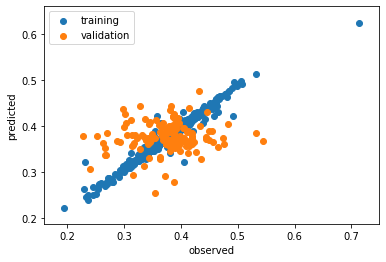

In [194]:
regression_evaluation(Y_training,
                      y_training_pred,
                      Y_validation,
                      y_validation_pred)